In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
# lip landmarks
lips_landmarks = {
    "lipsUpperOuter": [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291],
    "lipsLowerOuter": [146, 91, 181, 84, 17, 314, 405, 321, 375, 291],
    "lipsUpperInner": [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308],
    "lipsLowerInner": [78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 3],
}

# cheeks landmarks
cheeks_landmarks = [101, 330]

# eyelid landmarks
eyelid_landmarks = {
    "rightEyeLidUpper" : [247, 30, 29, 27, 28, 56, 190],
    "rightEyeLidLower" : [246, 161, 160, 159, 158, 157, 173],
    "leftEyeLidUpper" : [467, 260, 259, 257, 258, 286, 414],
    "leftEyeLidLower" : [466, 388, 387, 386, 385, 384, 398],
}

In [3]:
# MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

# face mesh detector
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True)


In [4]:
def detect_landmarks(src: np.ndarray, is_stream: bool = False):
    rgb_image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb_image)
    
    if result.multi_face_landmarks:
        return result.multi_face_landmarks[0]
    else:
        print("No face detected.")
        return None

In [5]:
def normalize_landmarks(landmarks, height, width, feature=None):
    normalized_points = []
    for idx in feature if feature else range(len(landmarks)):
        normalized_points.append(
            (int(landmarks[idx].x * width), int(landmarks[idx].y * height))
        )
    return np.array(normalized_points)

In [6]:
# lip mask
def lip_mask(src: np.ndarray, points_outer: np.ndarray, points_inner: np.ndarray, color: list):
    mask = np.zeros_like(src)
    mask = cv2.fillPoly(mask, [points_outer], color)
    mask = cv2.fillPoly(mask, [points_inner], (0, 0, 0))
    mask = cv2.GaussianBlur(mask, (3, 3), 3)
    return mask

In [7]:
# blush mask
def blush_mask(src: np.ndarray, points: np.ndarray, color: list, radius: int):
    mask = np.zeros_like(src)
    for point in points:
        mask = cv2.circle(mask, point, radius, color, cv2.FILLED)
        x, y = point[0] - radius, point[1] - radius
        mask[y:y + 2 * radius, x:x + 2 * radius] = vignette(mask[y:y + 2 * radius, x:x + 2 * radius], 12)
    return mask

In [8]:
# eyeshadow mask
def eyeshadow_mask(src: np.ndarray, upper_points: np.ndarray, lower_points: np.ndarray, color: list):
    mask = np.zeros_like(src)
    eye_region = np.concatenate([upper_points, lower_points[::-1]])
    mask = cv2.fillPoly(mask, [eye_region], color)
    mask = cv2.GaussianBlur(mask, (9, 9), 10)
    return mask

In [9]:
# soft vignette effect
def vignette(src: np.ndarray, sigma: int):
    height, width, _ = src.shape
    kernel_x = cv2.getGaussianKernel(width, sigma)
    kernel_y = cv2.getGaussianKernel(height, sigma)

    kernel = kernel_y * kernel_x.T
    mask = kernel / kernel.max()
    blurred = cv2.convertScaleAbs(src.copy() * np.expand_dims(mask, axis=-1))
    return blurred

In [10]:
def apply_makeup(src: np.ndarray, is_stream: bool, feature: str, show_landmarks: bool = False):
    ret_landmarks = detect_landmarks(src, is_stream)
    if ret_landmarks is None:
        return src
    
    height, width, _ = src.shape
    output = src.copy()

    # apply lip mask
    if feature == 'lips':
        # normalize landmarks for all lip regions
        upper_outer = normalize_landmarks(ret_landmarks.landmark, height, width, lips_landmarks["lipsUpperOuter"])
        lower_outer = normalize_landmarks(ret_landmarks.landmark, height, width, lips_landmarks["lipsLowerOuter"])
        upper_inner = normalize_landmarks(ret_landmarks.landmark, height, width, lips_landmarks["lipsUpperInner"])
        lower_inner = normalize_landmarks(ret_landmarks.landmark, height, width, lips_landmarks["lipsLowerInner"])

        # combine points for outer and inner lips
        outer_lip_points = np.concatenate([upper_outer, lower_outer[::-1]])
        inner_lip_points = np.concatenate([upper_inner, lower_inner[::-1]])

        # create the lip mask
        mask = lip_mask(src, outer_lip_points, inner_lip_points, [30, 0, 255]) # lip color BGR
        output = cv2.addWeighted(output, 1.0, mask, 0.3, 0.0) 

    # apply blush mask
    elif feature == 'blush':
        feature_landmarks = normalize_landmarks(ret_landmarks.landmark, height, width, cheeks_landmarks)
        if len(feature_landmarks) == 2:  
            mask = blush_mask(src, feature_landmarks, [0, 0, 255], 30) # blush color BGR
            output = cv2.addWeighted(output, 1.0, mask, 0.4, 0.0)
        else:
            print("Blush feature landmarks not properly detected!")

    # apply eyeshadow mask
    elif feature == 'eyeshadow':
        # normalize landmarks for both eyes
        right_upper = normalize_landmarks(ret_landmarks.landmark, height, width, eyelid_landmarks["rightEyeLidUpper"])
        right_lower = normalize_landmarks(ret_landmarks.landmark, height, width, eyelid_landmarks["rightEyeLidLower"])
        left_upper = normalize_landmarks(ret_landmarks.landmark, height, width, eyelid_landmarks["leftEyeLidUpper"])
        left_lower = normalize_landmarks(ret_landmarks.landmark, height, width, eyelid_landmarks["leftEyeLidLower"])

        # create masks for both eyes
        right_eye_mask = eyeshadow_mask(src, right_upper, right_lower, [255, 0, 0]) # R eye color BGR
        left_eye_mask = eyeshadow_mask(src, left_upper, left_lower, [255, 0, 0]) # L eye color BGR

        # combine eyeshadow masks with the output
        output = cv2.addWeighted(output, 1.0, right_eye_mask, 0.5, 0.0)
        output = cv2.addWeighted(output, 1.0, left_eye_mask, 0.5, 0.0)
    
    return output

In [21]:
image_path = 'images/no-makeup-girl-portrait.jpg' 
image = cv2.imread(image_path)

# apply lipcolor
output_image = apply_makeup(image, is_stream=False, feature='lips')

# apply blush
output_image = apply_makeup(output_image, is_stream=False, feature='blush')

# apply eyeshadow
output_image = apply_makeup(output_image, is_stream=False, feature='eyeshadow')

output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)


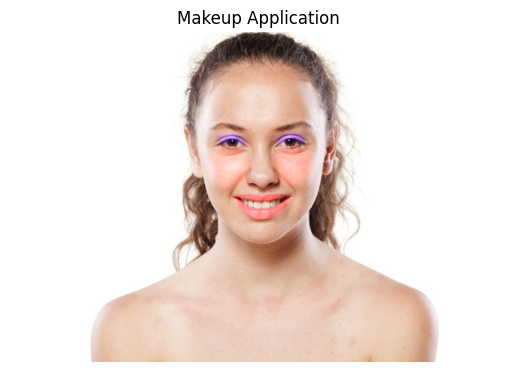

In [23]:
plt.imshow(output_image)
plt.axis('off')
plt.title("Makeup Application")
plt.show()